# Links

---

Harrison - https://omsweb.public-safety-cloud.com/jtclientweb/jailtracker/index/HARRISON_COUNTY_JAIL_MS

Yazoo - https://omsweb.public-safety-cloud.com/jtclientweb/jailtracker/index/Yazoo_County_MS/

In [ ]:
from typing import Union, Dict
from enum import Enum, unique

import pandas as pd
import os
import time

import urllib
import requests
import ssl
import certifi

from random import randint

from datetime import datetime
from pytz import timezone

from bs4 import BeautifulSoup

import threading
import IPython

# Used for debugging; pretty print JSON strings
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not os.path.exists('/content/drive/MyDrive/'):
    raise Exception("ERROR: Mount Google Drive before continuing!")

BASE_DIR = '/content/drive/MyDrive/Data Science for Social Good - Spring 2022/data/'

# Define directory that contains intermediate SSL certificates
CERT_DIR = BASE_DIR + 'certificates/'

# Define directories to save data
SCRAPE_DIR = BASE_DIR + 'scraped_files/'
DATA_DIR = SCRAPE_DIR + 'DATA/'

CURRENT_DATE = datetime.now(timezone('US/Eastern')).strftime('%m-%d-%Y')

# Create all directories on the given paths if needed
os.makedirs(f'{DATA_DIR}{CURRENT_DATE}', exist_ok=True)
print("Date used for scraping:", CURRENT_DATE)

Date used for scraping: 03-22-2022


# Helper Functions and Classes

---



In [16]:
@unique
class CountyWithCaptcha(Enum):
    DESOTO = 'DeSoto'
    FORREST = 'Forrest'
    HANCOCK = 'Hancock'
    HARRISON = 'Harrison'
    LAMAR = 'Lamar'
    MARION = 'Marion'
    PERRY = 'Perry'
    YAZOO = 'Yazoo'

    # Return Name, rather than CountyWithCaptcha.Name
    def __str__(self):
        return self.name


@unique
class CountyWithoutCaptcha(Enum):
    # The commented out counties only have the total bond, not bond by crime
    PEARL_RIVER = 'PearlRiver'
    JACKSON = 'Jackson'
    MADISON = 'Madison'
    # ADAMS = 'Adams'
    # CLAY = 'Clay'
    # JONES = 'Jones'
    # TUNICA = 'Tunica'

    # Return Name, rather than CountyWithoutCaptcha.Name
    def __str__(self):
        return self.name


# Define a custom type to pass into functions
County = Union[CountyWithCaptcha, CountyWithoutCaptcha]


def get_county_filename(county: County) -> str:
    return f'{str(CURRENT_DATE)}_{county.value}.csv'

In [17]:
jail_links = {
    CountyWithCaptcha.DESOTO: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/DeSoto_County_MS/',
    CountyWithCaptcha.FORREST: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Forrest_County_MS/',
    CountyWithCaptcha.HANCOCK: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/HANCOCK_COUNTY_MS/',
    CountyWithCaptcha.HARRISON: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/HARRISON_COUNTY_JAIL_MS/',
    CountyWithCaptcha.LAMAR: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Lamar_County_MS/',
    CountyWithCaptcha.MARION: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Marion_County_MS/',
    CountyWithCaptcha.PERRY: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Perry_County_MS/',
    CountyWithCaptcha.YAZOO: 'https://omsweb.public-safety-cloud.com/jtclientweb/Offender/Yazoo_County_MS/',
    CountyWithoutCaptcha.PEARL_RIVER: 'https://www.pearlrivercounty.net/sheriff/files/',
    CountyWithoutCaptcha.MADISON: 'https://mydcstraining.com/agencyinfo/MS/4360/inmate/',
}


In [18]:
def read_url(request: Union[str, urllib.request.Request]) -> str:
    NUM_SECONDS_TIMEOUT = 10

    ctx = ssl.create_default_context(ssl.Purpose.CLIENT_AUTH, cafile=certifi.where())
    response = urllib.request.urlopen(request, timeout=NUM_SECONDS_TIMEOUT, context=ctx)
    data = response.read()
    response.close()
    return data


def read_url_with_retries(url: str, use_headers: bool = False) -> str:
    if use_headers:
        user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
        headers = {'User-Agent': user_agent}
        request = urllib.request.Request(url, headers=headers)
    else:
        request = url

    # Try the connection until success or NUM_ATTEMPTS is exceeded
    NUM_ATTEMPTS = 5
    for _ in range(NUM_ATTEMPTS):
        try:
            return read_url(request)
        except urllib.error.URLError as str_error:
            time.sleep(0.5)
            print("Exception:", url, str_error)

    print("Request failed for", url)
    return None

# Add missing intermediate SSL certificates

---

This should only be run once per session.

According to https://stackoverflow.com/a/64835339, Python cannot automatically download intermediate SSL certificates. 

For Jackson, this results in an SSL: CERTIFICATE_VERIFY_FAILED error. We add the intermediate certificates found at: https://services.co.jackson.ms.us/jaildocket/_inmateList.php

In [19]:
with open(certifi.where(), 'a') as global_cert_file:
    for filename in os.listdir(CERT_DIR):
        with open(CERT_DIR + filename, 'r') as missing_cert_file:
            cert_data = missing_cert_file.read()
            global_cert_file.write('\n' + cert_data)

# Counties with Captchas Scraper

---



In [20]:
def county_with_captcha_scraper(county: CountyWithCaptcha, captcha_key: str):
    jail_url = jail_links[county]
    jail_record_data = requests.post(
        jail_url,
        json={'captchaKey': captcha_key}
    )
    jail_record_data_json = jail_record_data.json()
    offender_view_key = jail_record_data_json['offenderViewKey']
    num_offenders = len(jail_record_data_json['offenders'])
    print(county, "Number of offenders:", num_offenders)

    def get_inmate_url(arrest_num: str) -> str:
        def gen_random_num_with_n_digits(n: int) -> int:
            """Based on:
            https://stackoverflow.com/a/2673399
            """
            range_start = 10 ** (n - 1)
            range_end = (10 ** n) - 1
            return randint(range_start, range_end)

        # Apparently the offender view key is just a random number (and the length doesn't matter)?
        # We need an offender view key to make our request
        # We use the default length that the website uses, which is 9
        LEN_VIEW_KEY = 9
        random_offender_view_key = gen_random_num_with_n_digits(LEN_VIEW_KEY)
        return f'{jail_url}{arrest_num}/offenderbucket/{random_offender_view_key}'

    offender_data = []
    cur_num_processed = 0
    for offender in jail_record_data_json['offenders']:
        arrest_num = offender['arrestNo']
        inmate_url = get_inmate_url(arrest_num)
        inmate_data = requests.post(
            inmate_url,
            json={'captchaKey': captcha_key}
        )
        inmate_data_json = inmate_data.json()

        # Add basic data
        inmate = {
            'Arrest Number': arrest_num,
            'Cases': inmate_data_json['cases'],
            'Charges': inmate_data_json['charges'],
        }

        # Add special fields
        for field in inmate_data_json['offenderSpecialFields']:
            field_name = field['labelText'].strip(':')
            inmate[field_name] = field['offenderValue']

        offender_data.append(inmate)
        cur_num_processed += 1
        if cur_num_processed % 50 == 0:
            print(county, "Processed", cur_num_processed)

    filename = get_county_filename(county)
    df = pd.DataFrame(offender_data)
    df.to_csv(f'{DATA_DIR}{CURRENT_DATE}/{filename}', index=False)

# Jackson Script

---

Occasionally, Jackson will time out. We aren't sure what causes this, but the issue is usually gone when rerunning the scraper later in the day.

In [21]:
def jackson():
    def parse_inmate_card(page_data: BeautifulSoup) -> Dict:
        """
        Return info card and offense card details.

        Example html scraped of an offense box:
        [<div class="offenseItem"><p class="offenseTitle">POSSESSION WITH INTENT TO DISTRIBUTE A CONTROLLED SUBSTANCE</p><p class="offenseDetails">Felony - Bond: $0.00</p></div>, <div class="offenseItem"><p class="offenseTitle">POSSESSION OF A CONTROLLED SUBSTANCE - ALL OTHERS</p><p class="offenseDetails">Felony - Bond: $0.00</p></div>, <div class="offenseItem"><p class="offenseTitle">TRAFFICKING IN CONTROLLED SUBSTANCES</p><p class="offenseDetails">Felony - Bond: $0.00</p></div>]

        Example html scraped of an info box (the fields are always in the same order):
        [<p class="ilFieldName">Black Male</p>, <p class="ilFieldName">170 Pounds</p>, <p class="inmateInfo">5 Ft. 08 In. </p>, <p class="inmateInfo">Brown      Eyes </p>, <p class="inmateInfo">35 Years Old</p>, <p class="inmateInfo">Booking #:NJCADC0000023672</p>, <p class="inmateInfo red">Not Bondable</p>]

        """
        # Parse offenses 
        # Offenses is a list of dictionaries, where each dictionary contains information about the crime
        offenses = []
        offense_box = page_data.find('article', class_='ofcard').find_all('div', class_='offenseItem')
        for offense in offense_box:
            offense_title = offense.find('p', class_='offenseTitle').text
            offense_details = offense.find('p', class_='offenseDetails').text.split()
            offenses.append({
                'chargeDescription': offense_title, 
                'bondAmount': offense_details[-1][1:],
                'crimeType': offense_details[0],
            })

        def get_formatted_height(height: str) -> str:
            """Return height as:
            {feet}' {inches}"
            """
            return f'''{height[0]}' {height[2]}"'''

        # Parse basic details: height, eye color, age etc.
        # Some of the basic details are out of order since some are missing (default missing to empty string)
        inmate_info_box = page_data.find_all('p', class_='inmateInfo')
        if len(inmate_info_box) == 5:
            height_string = inmate_info_box[0].text.split()
            height = get_formatted_height(height_string)
            eye_color = inmate_info_box[1].text.split()[0]
            age = inmate_info_box[2].text.split()[0]
        else:
            height, eye_color, age = '', '', ''
            for detail in inmate_info_box:
                if detail.text[-4:] == 'Eyes':
                    eye_color = detail.text.split()[0]
                elif detail.text[-3:] == 'Old':
                    age = detail.text.split()[0]
                elif detail.text[-4:] == 'In. ':  # There is a random space in this string
                    height_string = detail.text.split()
                    height = get_formatted_height(height_string)

        # Race and sex format: "race sex", where we can have "not available" for race and some information can be missing (default missing to empty string)
        # Weight format: "x Pounds"
        inmate_field_box = page_data.find_all('p', class_='ilFieldName')
        if len(inmate_field_box) == 2:
            race_gender = inmate_field_box[0].text.split()
            race = race_gender[0] if race_gender[0] != 'Not' else 'N/A'
            sex = race_gender[-1] if race_gender[-1] != 'Available' else 'N/A'
            weight = f'{inmate_field_box[1].text.split()[0]} lbs'
        else:
            weight, sex, race = '', 'N/A', 'N/A'
            for detail in inmate_field_box:
                if detail.text[-6:] == 'Pounds':
                    weight = detail.text.split()[0] + ' lbs'
                else:
                    if str.lower(detail.text[-3:]) == 'male':
                        gender = detail.text.split()[-1]
                    if detail.text[:3] != 'Not':
                        race = detail.text.split()[0]

        return {
            'Current Age': age,
            'Height': height,
            'Weight': weight,
            'Eye Color': eye_color,
            'Race': race,
            'Sex': sex,
            'Charges': offenses,
        }

    # Example of inmate in website_data which is a dictionary
    # {
    #     "0":"421",
    #     "RowNum":"421",
    #     "1":"NJCADC0000026510",
    #     "Book_Number":"NJCADC0000026510",
    #     "2":"STALLWORTH",
    #     "Name_Last":"STALLWORTH",
    #     "3":"DESHAWN",
    #     "Name_Middle":"DESHAWN",
    #     "4":"TREVION",
    #     "Name_First_MI":"TREVION",
    #     "5":"08\/16\/2019",
    #     "BookDate":"08\/16\/2019",
    #     "6":"08\/23\/2019",
    #     "ArrestDate":"08\/23\/2019",
    #     "7":"PPD",
    #     "Arrest_Agency":"PPD",
    #     "8":"",
    #     "Name_Suffix":"",
    #     "9":"200978747                ",
    #     "ID_Number":"200978747                "
    # }

    # Obtain the total count of inmates
    # count_html is a bytes string containing the number of inmates
    count_url = 'https://services.co.jackson.ms.us/jaildocket/_inmateList.php?Function=count'
    count_html = read_url_with_retries(count_url)
    num_offenders = count_html.decode('utf-8')
    print("Jackson Number of offenders:", num_offenders)

    offender_data = []
    cur_num_processed = 0

    # While there is a page with inmate data, collect the inmate IDs
    page = 1
    while True:
        url = f'https://services.co.jackson.ms.us/jaildocket/_inmateList.php?Function=list&Page={page}'
        website_html = read_url_with_retries(url)
        website_data = json.loads(BeautifulSoup(website_html, 'html.parser').prettify())

        # Exit when there is no content on the page
        if len(website_data) < 1:
            break

        # Get details from the inmate card page and the inmate list page
        for inmate in website_data:
            inmate_id = inmate['ID_Number'].strip()
            url = f'https://services.co.jackson.ms.us/jaildocket/inmate/_inmatedetails.php?id={inmate_id}'
            inmate_html = read_url_with_retries(url)
            inmate_card_data = BeautifulSoup(inmate_html, 'html.parser')
            inmate_info = parse_inmate_card(inmate_card_data)

            # Store a row of information on an inmate
            inmate = {
                'Arrest Number': inmate_id,
                'First Name': str.upper(inmate['Name_First_MI']),
                'Middle Name': str.upper(inmate['Name_Middle']),
                'Last Name': str.upper(inmate['Name_Last']),
                'Suffix': str.upper(inmate['Name_Suffix']),
                'Arrest Date': inmate['ArrestDate'],
                'Booking Date': inmate['BookDate'],
                'Arrest Agency': str.upper(inmate['Arrest_Agency']),
                'Booking Number': inmate['Book_Number'],
            }

            # Merge the two dictionaries
            inmate.update(inmate_info)

            offender_data.append(inmate)
            cur_num_processed += 1
            if cur_num_processed % 50 == 0:
                print(county, "Processed", cur_num_processed)

        page += 1

    filename = get_county_filename(county)
    df = pd.DataFrame(offender_data)
    df.to_csv(f'{DATA_DIR}{CURRENT_DATE}/{filename}', index=False)

#PEARLRIVER_MADISON COMBO WOMBO

In [22]:
def pearlriver_madison(county: CountyWithoutCaptcha):
    base_url = jail_links[county]
    all_url = base_url + 'ICURRENT.HTM'

    def get_list_of_inmates_url(url):
        detail_urls = []
        web_html = read_url_with_retries(url, True)
        soup = BeautifulSoup(web_html, 'html.parser')
        suffix_set = soup.findAll('a')
        for inmate_entry in suffix_set:
            detail_urls.append(base_url + inmate_entry['href'])
        return detail_urls

    def get_info(url):
        inmate_detail = {}
        web_html = read_url_with_retries(url, True)
        soup = BeautifulSoup(web_html, 'html.parser')

        # Check if the link has content (check name is the fastest way)
        if soup.find('b', text='Name: ') == None:
            return None
        full_name = soup.find('b', text='Name: ').next_sibling.split()

        inmate_detail['First Name'] = full_name[0]
        inmate_detail['Last Name'] = full_name[len(full_name) - 1]

        # Middle name, changing it from an array to just a string
        full_mid = '' if len(full_name[1:len(full_name) - 1]) == 0 else full_name[1:len(full_name) - 1]
        tmp_mid = ''
        for i in full_mid:
            tmp_mid += i
        inmate_detail['Middle Name'] = tmp_mid

        inmate_detail['Current Age'] = soup.find('b', text='AGE:').next_sibling.strip()

        # Add the ' for the height (page shows 600, making it 6'00)
        height = soup.find('b', text='HGT: ').next_sibling.strip()
        inmate_detail['Height'] = height[0] + ' \'' + height[1:]
        inmate_detail['Weight'] = soup.find('b', text='WGT: ').next_sibling.strip()
        inmate_detail['Race'] = soup.find('b', text='RACE: ').next_sibling.strip()
        inmate_detail['Sex'] = soup.find('b', text='SEX: ').next_sibling.strip()
        inmate_detail['Hair'] = soup.find('b', text='HAIR: ').next_sibling.strip()
        inmate_detail['Eye'] = soup.find('b', text='EYE: ').next_sibling.strip()

        # A lot of inconsistency with this, so I just took it out
        # inmate_detail['Case Number'] = soup.find('b', text=' - Case#:').next_sibling.strip()

        inmate_detail['Booking Date'] = soup.find('b', text='INTAKE DATE: ').next_sibling.strip() + ' ' + soup.find('b',text='TIME:').next_sibling.strip()
        inmate_detail['Intake_num'] = soup.find('b', text='INTAKE #: ').next_sibling.strip()
        inmate_detail['Arresting Agency'] = soup.find('b', text='ARRESTING AGENCY: ').next_sibling.strip()

        charge_list_tag = soup.find('table', {'width': '100%', 'align': 'center', 'cellspacing': '2'}).findAll('tr')[2:]
        inmate_detail['Charges'] = ''
        # Append each charges into an dict
        for charge in charge_list_tag:
            bail_info = {}
            charge_info = charge.findAll('td')

            # Freaking weird symbol that wont go away with decode >:(
            bail_info['charge_description'] = charge_info[0].contents[0].strip().replace('ã', ' ')
            bail_info['charge_court'] = charge_info[1].contents[0].strip().replace('ã', ' ')
            if len(charge_info[2]) == 0:
                bail_info['charge_bond_amount'] = 0
            else:
                bail_info['charge_bond_amount'] = charge_info[2].contents[0].strip()

            inmate_detail['Charges'] = bail_info

        return inmate_detail

    all_info = pd.DataFrame()
    detail_urls = get_list_of_inmates_url(all_url)
    
    for inmate_url in detail_urls:
        info_arr = get_info(inmate_url)
        if info_arr != None:
            all_info = all_info.append(info_arr, ignore_index=True)
    
    filename = get_county_filename(county)
    all_info.to_csv(f'{DATA_DIR}{CURRENT_DATE}/{filename}', index=False)

# Main Web Scraper

---



In [ ]:
class WebScraperThread(threading.Thread):
    def __init__(self, thread_id: int, county: County, captcha_key: str = None):
        threading.Thread.__init__(self)
        self.thread_id = thread_id
        self.county = county
        self.captcha_key = captcha_key

    def run(self):
        print("Starting", self.county, flush=True)

        if self.county in CountyWithCaptcha:
            county_with_captcha_scraper(self.county, self.captcha_key)
        # elif self.county == CountyWithoutCaptcha.PEARL_RIVER:
        #     pearl_river()
        # elif self.county == CountyWithoutCaptcha.CLAY:
        #     clay()
        # elif self.county == CountyWithoutCaptcha.ADAMS:
        #     adams()
        elif self.county == CountyWithoutCaptcha.JACKSON:
            jackson()
        # elif self.county == CountyWithoutCaptcha.JONES:
        #     jones()
        # elif self.county == CountyWithoutCaptcha.MADISON:
        #     madison()
        # elif self.county == CountyWithoutCaptcha.TUNICA:
        #     tunica()
        else:
            raise Exception("County not found:", self.county, flush=True)

        print("Exiting", self.county, end='\n\n', flush=True)


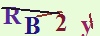

RB2y
StartingStarting  FORREST
StartingDESOTO
Starting HARRISON
Starting LAMAR
 Starting MARION
HANCOCK
Starting PERRY
StartingStarting JACKSON YAZOO

Jackson Number of offenders: 423
PERRY Number of offenders: 35
LAMAR Number of offenders: 91
HANCOCK Number of offenders: 259
YAZOO Number of offenders: 258
HARRISON Number of offenders: 650
DESOTO Number of offenders: 492
MARION Number of offenders: 246
FORREST Number of offenders: 272
JACKSON Processed 50
JACKSON Processed 100
Exiting PERRY

FORREST Processed 50
HANCOCK Processed 50
MARION Processed 50
HARRISON Processed 50
DESOTO Processed 50
YAZOO Processed 50
JACKSON Processed 150
LAMAR Processed 50
JACKSON Processed 200
FORREST Processed 100
JACKSON Processed 250
MARION Processed 100
HANCOCK Processed 100
HARRISON Processed 100
DESOTO Processed 100
YAZOO Processed 100
Exiting LAMAR

JACKSON Processed 300
JACKSON Processed 350
FORREST Processed 150
MARION Processed 150
HANCOCK Processed 150
HARRISON Processed 150
JACKSON Processed 4

In [ ]:
threads = []
thread_id = 1

# Get a captcha key for the counties that require captchas
is_captcha_matched = False
while not is_captcha_matched:
    captcha_data = requests.get('https://omsweb.public-safety-cloud.com/jtclientweb/captcha/getnewcaptchaclient')
    image = captcha_data.json()['captchaImage']

    # To be used later for automated captcha solver
    # # Save the image to a file
    # import base64
    # import matplotlib.pyplot as plt
    # img = image.split('base64,')[-1]
    # x = base64.decodebytes(img.encode('ascii'))
    # with open('captcha.jpg', 'wb') as f:
    #     f.write(x)

    html = f'<img src="{image}"/>'
    IPython.display.display(IPython.display.HTML(html))
    user_code = input()

    captcha_response_data = requests.post(
        'https://omsweb.public-safety-cloud.com/jtclientweb/Captcha/validatecaptcha',
        json={'userCode': user_code, 'captchaKey': captcha_data.json()['captchaKey']}
    )
    is_captcha_matched = captcha_response_data.json()['captchaMatched']
    captcha_key = captcha_response_data.json()['captchaKey']

    if not is_captcha_matched:
        print("Incorrect captcha")

for county in CountyWithCaptcha:
    thread = WebScraperThread(thread_id, county, captcha_key)
    threads.append(thread)
    thread_id += 1

for county in CountyWithoutCaptcha:
    thread = WebScraperThread(thread_id, county)
    threads.append(thread)
    thread_id += 1

for t in threads:
    t.start()

# Wait for all threads to complete
for t in threads:
    t.join()

print("Finished scraping")